# Outliers

## Initialization

In [1]:
# Importing verticapy
from verticapy import *
# Creating a connection
new_auto_connection({"host": "10.211.55.14", 
                     "port": "5433", 
                     "database": "testdb", 
                     "password": "XxX", 
                     "user": "dbadmin"},
                    name = "VerticaDSN")
# Set the primary auto-connection
change_auto_connection("VerticaDSN")

In [2]:
verticapy.__version__

'0.6.1'

In [3]:
%load_ext verticapy.sql

In [4]:
%%sql
DROP SCHEMA IF EXISTS outliers_exercise CASCADE;
CREATE SCHEMA outliers_exercise;

DROP
CREATE


## Dataset Creation

In [5]:
from verticapy.datasets import gen_dataset
from datetime import datetime

# Generating different transactions

# Regular Transactions are between 0 and 100$. They are mostly during the Business
# hours but can happen outsides
regular_transaction_business_hours = gen_dataset({"hour": {"type": float, "range": [8.0, 20.0]},
                                                  "amount": {"type": float, "range": [0.0, 100.0]},
                                                  "category": {"type": str, "values": ["Regular"]}},
                                                  nrows=300,)
regular_transaction = gen_dataset({"hour": {"type": float, "range": [0.0, 24.0]},
                                   "amount": {"type": float, "range": [0.0, 100.0]},
                                   "category": {"type": str, "values": ["Regular"]}},
                                   nrows=100,)
# Some high transactions can occur sometimes. However they can only happen during the
# Business hours and they are between 3000 and 20000$.
high_transaction = gen_dataset({"hour": {"type": float, "range": [8.0, 20.0]},
                                "amount": {"type": float, "range": [3000.0, 20000.0]},
                                "category": {"type": str, "values": ["High"]},},
                               nrows=15,)
# Fraudulent Transactions are happening during night and are between 300 and 1000$.
fraudulent_transaction =  gen_dataset({"hour": {"type": float, "range": [2.0, 5.0]},
                                       "amount": {"type": float, "range": [300.0, 1000.0]},
                                       "category": {"type": str, "values": ["Fraud"]},},
                                       nrows=20)
# Our dataset will combine all the generated ones
bank_transaction = regular_transaction.append(regular_transaction_business_hours).append(
                                              high_transaction).append(
                                              fraudulent_transaction).to_db("outliers_exercise.transactions",
                                                                            relation_type="table",
                                                                            inplace=True)

## Data Exploration

<AxesSubplot:xlabel='"hour"', ylabel='"amount"'>

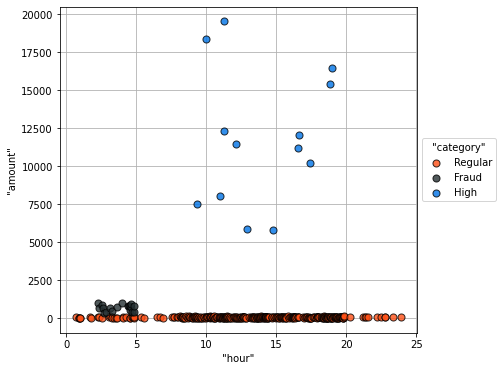

In [6]:
bank_transaction.scatter(["hour", "amount"], catcol="category",)

<AxesSubplot:xlabel='"hour"', ylabel='"amount"'>

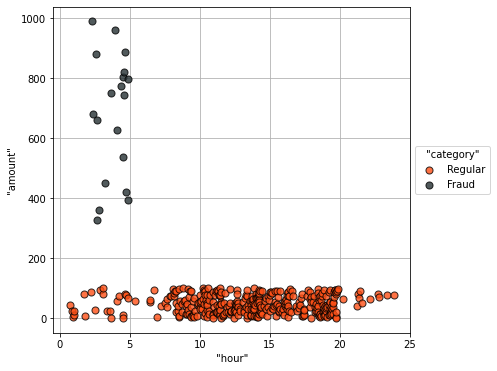

In [7]:
bank_transaction.search("amount < 2000").scatter(["hour", "amount"], catcol="category",)

## Global Outliers Detection

<AxesSubplot:xlabel='"hour"', ylabel='"amount"'>

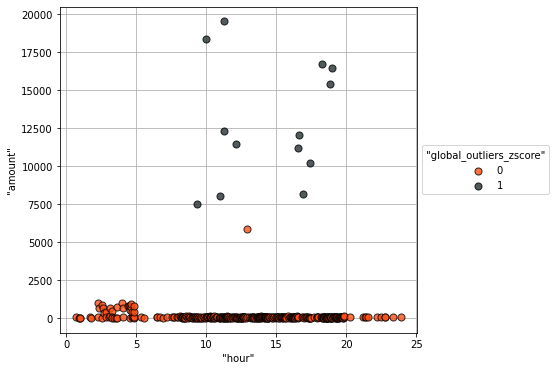

In [8]:
# ZSCORE can catch very high transactions but not fraudulent transactions
bank_transaction.outliers(columns = ["hour", "amount"],
                          name = "global_outliers_zscore",
                          threshold = 3,
                          robust = False)
bank_transaction.scatter(["hour", "amount"], catcol="global_outliers_zscore",)

<AxesSubplot:xlabel='"hour"', ylabel='"amount"'>

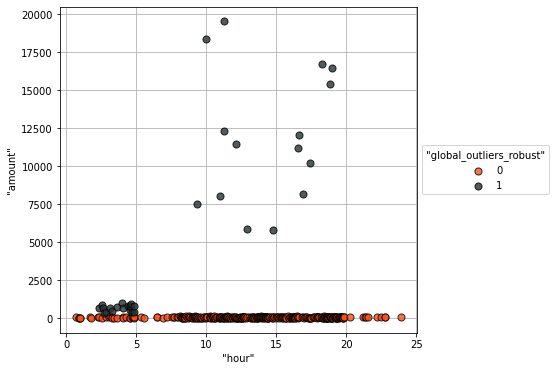

In [9]:
# Robust ZSCORE can catch anomalies and high transactions
bank_transaction.outliers(columns = ["hour", "amount"],
                          name = "global_outliers_robust",
                          threshold = 3,
                          robust = True)
bank_transaction.scatter(["hour", "amount"], catcol="global_outliers_robust",)

## Data Preparation & Modeling

In [10]:
from verticapy.learn.preprocessing import Normalizer

model_robust = Normalizer("outliers_exercise.robust_normalizer", method="robust_zscore")
model_robust.fit(bank_transaction, ["hour", "amount"])



details
column_name| median |  mad   
-----------+--------+--------
   hour    |13.59527| 5.11881
  amount   |49.65349|41.51213

### Pipeline Model

<AxesSubplot:xlabel='"hour"', ylabel='"amount"'>

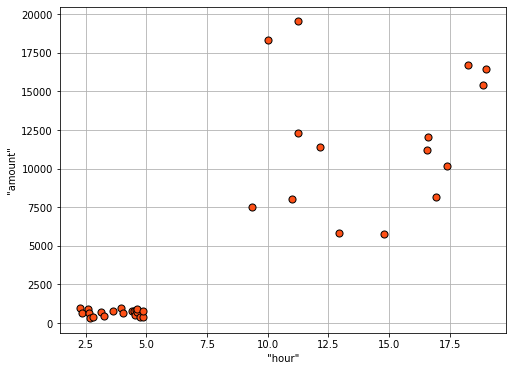

In [11]:
# We need to normalize the data in order to use ML algorithms which
# are sensible to the p-distance
bank_transaction_anomaly = bank_transaction.search("global_outliers_robust = 1")
bank_transaction_anomaly.scatter(["hour", "amount"],)

<AxesSubplot:xlabel='"hour"', ylabel='"amount"'>

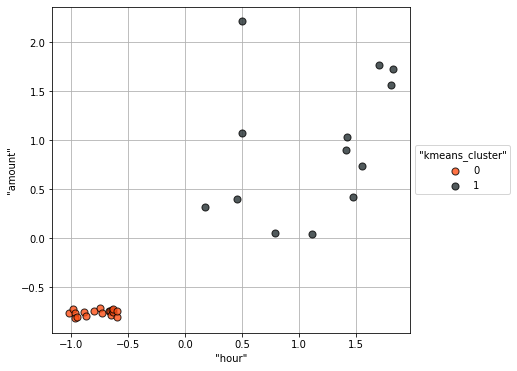

In [12]:
from verticapy.learn.pipeline import Pipeline
from verticapy.learn.preprocessing import Normalizer
from verticapy.learn.cluster import KMeans

model = Pipeline([("normalizer_bank", Normalizer("outliers_exercise.fraud_normalizer")),
                  ("kmeans_bank"    , KMeans("outliers_exercise.fraud_kmeans", 
                                             n_cluster=2, init=[(-1.0, -1.0), (0.0, 0.0),]))])
model.fit(bank_transaction_anomaly,
          ["hour", "amount"])
model[-1].plot()

### Model Deployment

#### in-DB = Near Real-Time

In [13]:
# Data are already in Vertica so the model is already deployed
bank_transaction = model.predict(bank_transaction, name="cluster")
bank_transaction["is_fraud"] = "global_outliers_robust AND cluster=0"

In [14]:
bank_transaction.search("is_fraud AND category = 'Fraud'").shape()[0]

20

In [15]:
bank_transaction.search("category = 'Fraud'").shape()[0]

20

In [16]:
print(bank_transaction.current_relation())

(
   SELECT
     "hour",
     "amount",
     "category",
     "global_outliers_zscore",
     "global_outliers_robust",
     "cluster",
     global_outliers_robust AND cluster=0 AS "is_fraud" 
   FROM
 (
   SELECT
     "hour",
     "amount",
     "category",
     "global_outliers_zscore",
     "global_outliers_robust",
     "cluster" 
   FROM
 (
   SELECT
     "hour",
     "amount",
     "category",
     "global_outliers_zscore",
     "global_outliers_robust",
     "cluster" 
   FROM
 (
   SELECT
     "hour",
     "amount",
     "category",
     "global_outliers_zscore",
     "global_outliers_robust",
     APPLY_KMEANS("hour", "amount" USING PARAMETERS model_name = 'outliers_exercise.fraud_kmeans', match_by_pos = 'true') AS "cluster" 
   FROM
 (
   SELECT
     "hour",
     "amount",
     "category",
     "global_outliers_zscore",
     "global_outliers_robust" 
   FROM
 (
   SELECT
     APPLY_NORMALIZE("hour", "amount", "category", "global_outliers_zscore", "global_outliers_robust" USING

#### At the source of the Data Stream = Real-Time

In [17]:
# We need to deploy the model outside Vertica

# We export the Robust ZSCORE function
robust_model = model_robust.to_python(name="robust_model")
print(model_robust.to_python(return_str=True, name="robust_model"))

def robust_model(X):
	import numpy as np
	median_values = np.array([13.5952674839646, 49.653486837633])
	mad_values = np.array([5.11881176197976, 41.5121293253358])
	return (X - median_values) / mad_values



In [18]:
# We export the Pipeline Function
kmeans_model = model.to_python(name="kmeans_model")
print(model.to_python(return_str=True, name="kmeans_model"))

def kmeans_model(X):
	def normalizer_bank(X):
		import numpy as np
		avg_values = np.array([8.32508097871074, 5502.59606521976])
		std_values = np.array([5.83078724833864, 6348.54686397911])
		return (X - avg_values) / std_values
	
	def kmeans_bank(X):
		import numpy as np
		centroids = np.array([[-0.783949292672451, -0.759964593625353], [1.04526572356327, 1.0132861248338]])
		result = []
		for centroid in centroids:
			result += [np.sum((np.array(centroid) - X) ** 2, axis=1) ** (1 / 2)]
		result = np.column_stack(result)
		result = np.argmin(result, axis=1)
		return result
	
	return kmeans_bank(normalizer_bank(X))


In [19]:
# We merge our 2 functions in a global function
import numpy as np
def anomaly_detection(X):
    def apply_row(X):
        x = robust_model([X])
        if x[0][0] < 3 and x[0][1] < 3:
            return False
        else:
            x = kmeans_model([X])
            return x[0] == 0
    return np.apply_along_axis(apply_row, 1, X)

In [20]:
anomaly_detection([[3, 200]])

array([ True])

In [21]:
anomaly_detection([[14, 50]])

array([False])

In [22]:
# We can deploy our model at the source of the data stream

import random

N = 10000
i, k = 0, 0
while True:
    if random.random() < 0.05:
        hour = random.random() * 3 + 2
        amount = random.random() * 700 + 300
    else:
        hour = random.random() * 24
        amount = random.random() * 100
    transaction = [hour, amount]
    if anomaly_detection([transaction]):
        print("Anomalous Transaction: {}".format(transaction))
        k += 1
    i += 1
    if i > N:
        print("Number of anomalies: {} among {} transactions".format(k, N))
        break

Anomalous Transaction: [3.195646094565477, 314.0541205420539]
Anomalous Transaction: [3.600558884047926, 456.33396570785123]
Anomalous Transaction: [2.5644292876661883, 340.28586294984194]
Anomalous Transaction: [4.95784420555654, 608.614196629341]
Anomalous Transaction: [4.415732003851933, 510.9440908790514]
Anomalous Transaction: [4.741804921035648, 662.4786165679719]
Anomalous Transaction: [4.304146580672732, 532.6912795318493]
Anomalous Transaction: [4.647016178675492, 468.1484981288836]
Anomalous Transaction: [2.672963966085935, 318.37659625575145]
Anomalous Transaction: [2.1613863019431716, 907.6154042676931]
Anomalous Transaction: [3.8805105760495313, 419.8464602984234]
Anomalous Transaction: [3.8663545060990514, 908.2803194442765]
Anomalous Transaction: [4.879520705116624, 987.801796750608]
Anomalous Transaction: [3.2553288619220053, 660.1976633854924]
Anomalous Transaction: [3.758496296038748, 778.7787750453812]
Anomalous Transaction: [4.6926778819379305, 685.9868229210183]
An

Anomalous Transaction: [2.9235819875310054, 439.29428349261536]
Anomalous Transaction: [2.0318709704910543, 566.6776402393534]
Anomalous Transaction: [4.110536551228099, 796.8455225142118]
Anomalous Transaction: [4.469732049943151, 953.1851117533458]
Anomalous Transaction: [2.0002351421254554, 329.6747340688548]
Anomalous Transaction: [3.393467283096, 619.918318222192]
Anomalous Transaction: [4.67384129554797, 988.4331946992977]
Anomalous Transaction: [4.126429243411758, 540.8826109354421]
Anomalous Transaction: [3.571082283848251, 521.9926575198061]
Anomalous Transaction: [4.412114377283622, 314.56762904163025]
Anomalous Transaction: [3.0498610324995195, 927.1242577044382]
Anomalous Transaction: [3.575530855380382, 934.8740438259327]
Anomalous Transaction: [2.9556466984634877, 514.3665431471956]
Anomalous Transaction: [2.5731196158407883, 434.8863187481071]
Anomalous Transaction: [3.2969951935675503, 822.9477391646964]
Anomalous Transaction: [2.28886591496544, 604.1414901314263]
Anoma

Anomalous Transaction: [2.0721853555543763, 848.6801395174145]
Anomalous Transaction: [3.1841624834875057, 545.5991825479731]
Anomalous Transaction: [2.5088890263503085, 787.8748279247334]
Anomalous Transaction: [3.7246582231107395, 781.218949914316]
Anomalous Transaction: [3.472899077351385, 985.8716900958281]
Anomalous Transaction: [4.4888011509929475, 739.0524795812495]
Anomalous Transaction: [4.467209207311496, 786.2239956893659]
Anomalous Transaction: [4.632184467229663, 871.689254361582]
Anomalous Transaction: [4.540633969518165, 909.6228354932391]
Anomalous Transaction: [3.010680692517554, 958.3019021510812]
Anomalous Transaction: [2.2387623659964446, 954.5160945662394]
Anomalous Transaction: [4.69537675123601, 743.0255278516092]
Anomalous Transaction: [4.970624350194168, 683.7881290002275]
Anomalous Transaction: [2.6226696379260206, 780.5058854268295]
Anomalous Transaction: [2.185428421500371, 617.5921978241332]
Anomalous Transaction: [4.715631912823303, 634.8319248374528]
Anom

Anomalous Transaction: [4.784482537787584, 561.3169617189733]
Anomalous Transaction: [3.438972866321467, 739.7503570288766]
Anomalous Transaction: [3.1211254812808913, 741.2803908041451]
Anomalous Transaction: [4.949221143147855, 374.8244233913141]
Anomalous Transaction: [4.918596295360308, 537.7402064182875]
Anomalous Transaction: [3.7784759218783237, 948.7761708604952]
Anomalous Transaction: [4.372818112250722, 394.53507178050825]
Anomalous Transaction: [3.0134375111095317, 898.2456247053635]
Anomalous Transaction: [4.783327763456179, 946.1459322345339]
Anomalous Transaction: [4.598987641694066, 644.5307863526492]
Anomalous Transaction: [2.513945573981591, 663.271406428302]
Anomalous Transaction: [2.793655408849516, 306.2985041181024]
Anomalous Transaction: [3.4882399682995104, 762.435352211431]
Anomalous Transaction: [3.2714411322725296, 433.97485073345183]
Anomalous Transaction: [2.1229856085945533, 829.0501409290408]
Anomalous Transaction: [2.9343915299974914, 389.71978735790253]
